# RNN Based Language Model From Scratch

In this notebook, I have tried to implement the part 3 of Andrej Karpathy's `Makemore` series, and my notes from the lecture.

In [1]:
# imports
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [ ]:
# Read Data
words = open(r'../names.txt', 'r').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [ ]:
# Building vocabulary and Basic Character encoding and decoding

chars = sorted(list(set(''.join(words)))) # Get all the unique chars in sorted order

stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print("itos: ", itos)
print("Vocab Size is: ", vocab_size)

itos:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocab Size is:  27


### Building the Dataset

Since this is a character level language model, we will be predicting the next in a sequence of some `block_size` elements. That is, if `block_size=3`, then our model will be predicting the fourth letter in a sequence of three characters. You can think of block size as the context length.

In [9]:
block_size = 3 

def build_dataset(words):
    X, Y = [ ], [ ]

    for w in words:
        context = [0] * block_size # For start of the word, have a padded context
        for char in w + ".":
            idx = stoi[char]
            X.append(context)
            Y.append(idx)

            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [10]:
import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words=words[:n1])
X_val, Y_val = build_dataset(words=words[n1:n2])
X_test, Y_test = build_dataset(words=words[n2:])

print("Train sizes: ", X_train.shape, Y_train.shape)
print("Validation Sizes: ", X_val.shape, Y_val.shape)
print("Test Sizes: ", X_test.shape, Y_test.shape)

Train sizes:  torch.Size([182437, 3]) torch.Size([182437])
Validation Sizes:  torch.Size([22781, 3]) torch.Size([22781])
Test Sizes:  torch.Size([22928, 3]) torch.Size([22928])


### Revisiting MLP Code

In [16]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g)


parameters = [C, W1, b1, W2, b2]
print("Total Parameters: ", sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

Total Parameters:  11897


In [17]:
epochs = 20000
batch_size = 32
lossi = [ ]

for i in range(epochs):

    # Construct the minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[idxs], Y_train[idxs]

    # Forward pass
    embeddings = C[X_batch]
    concatenated_embeddings = embeddings.view(embeddings.shape[0], -1) # Concatenate the embeddings
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2 # Output layer

    loss = F.cross_entropy(logits, y_batch) # PyTorch will apply softmax internally

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 10_000 else 0.01

    for p in parameters:
        p.data -= lr * p.grad

    if i % 1000 == 0:
        print(f"{i:7d}/{epochs:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/  20000: 25.5262
   1000/  20000: 3.5105
   2000/  20000: 2.6203
   3000/  20000: 3.1271
   4000/  20000: 2.8015
   5000/  20000: 2.7176
   6000/  20000: 2.8684
   7000/  20000: 2.6495
   8000/  20000: 2.3124
   9000/  20000: 2.6709
  10000/  20000: 1.8494
  11000/  20000: 2.1175
  12000/  20000: 2.2411
  13000/  20000: 2.2771
  14000/  20000: 2.7150
  15000/  20000: 2.2039
  16000/  20000: 2.5933
  17000/  20000: 2.4171
  18000/  20000: 2.2371
  19000/  20000: 2.6148


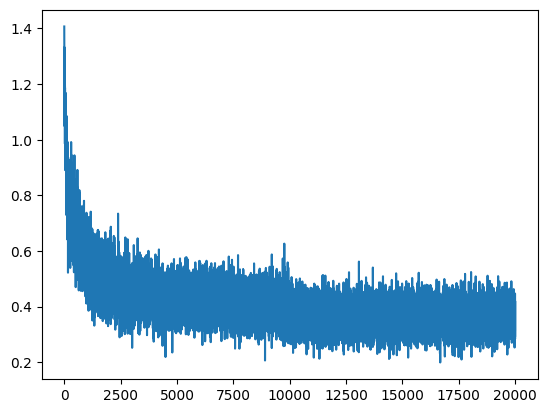

In [18]:
plt.plot(lossi)

In [21]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': [X_train, Y_train], 
        'test': [X_test, Y_test], 
        'val': [X_val, Y_val]
    }[split]

    embeddings = C[x]
    concatenated_embeddings = embeddings.view(embeddings.shape[0], -1)
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2 # Output layer

    loss = F.cross_entropy(logits, y) # PyTorch will apply softmax internally

    print(f"For {split}, loss was: {loss.item()}")

split_loss('train')
split_loss('val')

For train, loss was: 2.3057711124420166
For val, loss was: 2.3421437740325928


##### Predictions Using the Model

In [24]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = [ ]
    context = [0] * block_size

    while True:

        embeddings = C[torch.tensor([context])]
        h = torch.tanh(embeddings.view(1, -1) @ W1  + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        idx = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [idx]

        out.append(idx)

        if idx == 0:
            break

    print("".join(itos[i] for i in out))

mri.
ammyanniee.
mad.
ryah.
rethan.
engramo.
azeeph.
eliigell.
jen.
ede.
sustanar.
kayziostara.
noshurergahiries.
kinie.
jelinnn.
pucanu.
mayve.
ryy.
juliel.
ylay.


### Pro Tip:

When training neural networks, you should always have a rough intuition of what the loss should be at initialization. Think in terms of what the problem is and what the model setup is to get an idea of this. Do some research online also. For example, in the MLP case, **at initialization**, we don't have any reason to believe that our model should assign higher probability to any of the characters. Thus, initially, the probabilities assigned to each character should be equal- $1/27$. Since the loss is negative log likelihood, the loss we should expect at initialization is: $-torch.tensor(1/27.0).log()=3.295$

### Better Initialization

Notice how the actual loss is way worse than the expected loss. So, there's something wrong with the initialization. Ideally, we want the `logits` ( the final layer values before we apply softmax ) to be roughly equal for all characters, because that will give us roughly uniform probabilities for all characters, i.e. the loss that we expect. At the moment, the logits are taking extreme values which is giving high initial loss. See the below cell for an example of this.

In [35]:
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

epochs = 1
batch_size = 32
lossi = [ ]

for i in range(epochs):

    # Construct the minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[idxs], Y_train[idxs]

    # Forward pass
    embeddings = C[X_batch]
    concatenated_embeddings = embeddings.view(embeddings.shape[0], -1) # Concatenate the embeddings
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2 # Output layer

    loss = F.cross_entropy(logits, y_batch) # PyTorch will apply softmax internally

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 10_000 else 0.01

    for p in parameters:
        p.data -= lr * p.grad

print("Loss: ", loss.item())
print("Logits: ", logits[0])

Loss:  23.761310577392578
Logits:  tensor([ -2.9895, -10.7259,  11.5962,  -0.8956,  -0.6400,   5.4567,   1.1519,
         16.1026,  11.0054, -13.5825,  -0.5682,   7.2399,  21.2001,  17.9306,
         29.7785,   9.4731,  10.3627,  15.3446, -11.1299,  21.2104, -13.5997,
          2.1821, -13.4498,   4.9201,   7.2097, -13.4729,  -7.7893],
       grad_fn=<SelectBackward0>)


#### How to Get Logits Closer to Zero?

Since `logits = activations * W2 + b2`, we can reduce the values of $b2 and W2$ at initialization so that logits don't take randomly extreme values.

In [ ]:
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Make W2 smaller
b2 = torch.randn(vocab_size,                      generator=g) * 0.0 # Make b2 smaller

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

epochs = 1
batch_size = 32
lossi = []

for i in range(epochs):

    # Construct the minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[idxs], Y_train[idxs]

    # Forward pass
    embeddings = C[X_batch]
    concatenated_embeddings = embeddings.view(
        embeddings.shape[0], -1)  # Concatenate the embeddings
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2  # Output layer

    # PyTorch will apply softmax internally
    loss = F.cross_entropy(logits, y_batch)

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 10_000 else 0.01

    for p in parameters:
        p.data -= lr * p.grad

print("Loss: ", loss.item())

Loss:  3.3084709644317627


The loss is much closer to what we expect. 

But **Pro Tip:** You don't want the weights of the neural net to be zero. You want them to be small but not zero.

Let's let the training run to see how loss behaves now with this improved initialization.

In [38]:
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Make W2 smaller
b2 = torch.randn(vocab_size,                      generator=g) * 0.0 # Make b2 smaller

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

epochs = 20_000
batch_size = 32
lossi = []

for i in range(epochs):

    # Construct the minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[idxs], Y_train[idxs]

    # Forward pass
    embeddings = C[X_batch]
    concatenated_embeddings = embeddings.view(
        embeddings.shape[0], -1)  # Concatenate the embeddings
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2  # Output layer

    # PyTorch will apply softmax internally
    loss = F.cross_entropy(logits, y_batch)

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 10_000 else 0.01

    for p in parameters:
        p.data -= lr * p.grad

    if i % 1000 == 0:
        print(f"{i:7d}/{epochs:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

print("Loss: ", loss.item())

      0/  20000: 3.3042
   1000/  20000: 2.3162
   2000/  20000: 2.0227
   3000/  20000: 2.4296
   4000/  20000: 2.4050
   5000/  20000: 2.4665
   6000/  20000: 2.6894
   7000/  20000: 2.1206
   8000/  20000: 2.7971
   9000/  20000: 2.3439
  10000/  20000: 2.3008
  11000/  20000: 1.9749
  12000/  20000: 2.3511
  13000/  20000: 2.1149
  14000/  20000: 2.4707
  15000/  20000: 2.5113
  16000/  20000: 2.0083
  17000/  20000: 2.3844
  18000/  20000: 2.1596
  19000/  20000: 1.8818
Loss:  2.0451409816741943


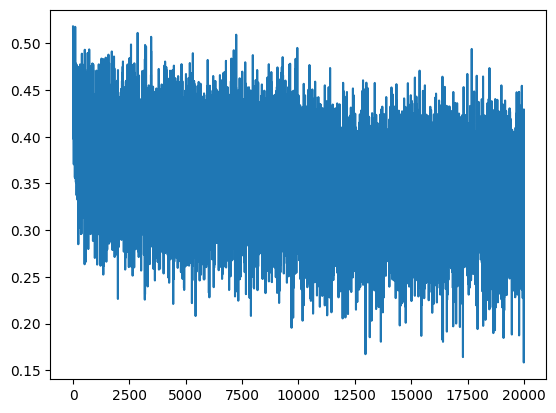

In [ ]:
plt.plot(lossi)

In [ ]:
split_loss('train'), split_loss('val')

For train, loss was: 2.1784121990203857
For val, loss was: 2.2251222133636475


(None, None)

The previous loss was around 2.3 and now it is slightly improved. Think about this: In the initial epochs, the model was squishing down the values of W2 and b2 and that was wasting epochs. But now, since we've already initialized them to lower values, these initial epochs are not wasted- as evidenced by the two loss plots.

### Improving Tanh

In [39]:
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

epochs = 1
batch_size = 32
lossi = [ ]

for i in range(epochs):

    # Construct the minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[idxs], Y_train[idxs]

    # Forward pass
    embeddings = C[X_batch]
    concatenated_embeddings = embeddings.view(embeddings.shape[0], -1) # Concatenate the embeddings
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2 # Output layer

    loss = F.cross_entropy(logits, y_batch) # PyTorch will apply softmax internally

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 10_000 else 0.01

    for p in parameters:
        p.data -= lr * p.grad

    break

print("activations: ", activations)

activations:  tensor([[ 0.9998,  0.8901,  0.9995,  ...,  0.9965,  0.8952, -0.8968],
        [ 0.9999,  0.8990,  1.0000,  ..., -0.9632, -0.9210, -0.5609],
        [-0.9861, -0.9992,  0.9512,  ..., -0.2763,  0.9999, -0.7673],
        ...,
        [ 0.9997, -0.9741, -0.9999,  ...,  0.3980,  1.0000, -0.9998],
        [ 0.4245,  0.9983,  0.8884,  ...,  0.7165,  0.9994,  0.9978],
        [-0.9848, -0.9999, -0.3301,  ...,  0.9898, -0.9831,  0.9549]],
       grad_fn=<TanhBackward0>)


(array([62.,  6.,  5.,  1.,  2.,  1.,  1.,  0.,  3.,  0.,  0.,  0.,  0.,
         2.,  0.,  1.,  0.,  1.,  1.,  1.,  4.,  1.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  1.,  2.,  3.,  3.,  2.,  1.,  3.,  8., 80.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

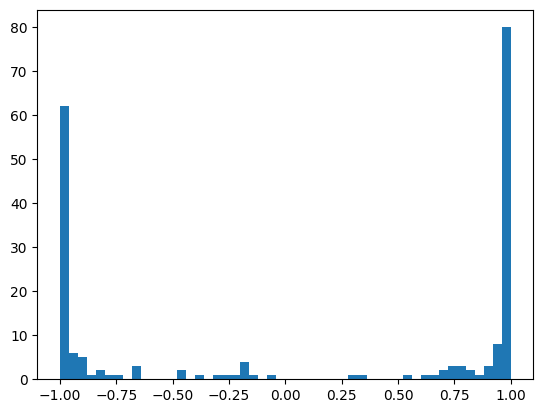

In [41]:
plt.hist(h.view(-1).tolist(), 50)

Most of the activations are at -1 or 1 at initialization. Remember the derivative of tanh? It was $(1-t**2)$. This means that when the activations are -1 or 1, then their gradient becomes zero. So, at initialization itself, these neurons become dead neurons. If the value of `t==0`, then you have maximum gradient, which is 1, i.e. the gradient just passes through. But in all other cases, the gradient decreases.

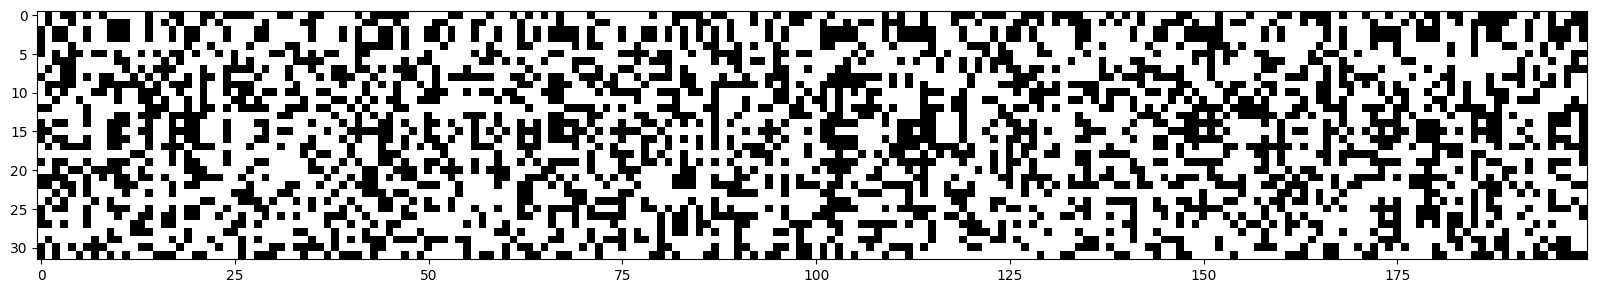

In [ ]:
# White = True, Black = False
plt.figure(figsize=(20, 10))
plt.imshow(activations.abs() > 0.99, cmap='gray', interpolation='nearest')

All the white cells represent the instances where the tanh is giving extreme values. X-axis is the number of neurons. Y-axis is the sample.
If an entire column is white, that's a cause for big trouble. That means that for any of the input, the neuron didn't fire. If the neuron is not firing for any input, then it's a dead neuron.

Sigmoid, Tanh, ReLU are neurons where such situation can occur. At times, this happens during initialization. At times, this happens during optimization- when your learning rate is too high, for instance.

Here, at initialization, many neurons are not getting gradients, which is not good. So what can be done to improve on this?

#### Better Preactivations

The values of the preactivations are too extreme, that's what is being fed into the tanh and that is making the tanh go closer to -1 and 1. For instance, in the plot below, we see the values of preactivations are between [-20, 20], which is quite extreme. We can fix this by doing the same thing that we did for the activations- scale down the initial weights and biases.

(array([  2.,   1.,   0.,   1.,   4.,   4.,   7.,  13.,  10.,   2.,  16.,
         39.,  50.,  56.,  74., 106., 144., 178., 176., 287., 298., 349.,
        366., 371., 424., 422., 384., 393., 378., 301., 313., 265., 260.,
        176., 124.,  94.,  88.,  71.,  52.,  31.,  15.,  12.,  11.,  14.,
          6.,   5.,   3.,   0.,   3.,   1.]),
 array([-21.32138824, -20.47886902, -19.63634979, -18.79383057,
        -17.95131134, -17.10879211, -16.26627289, -15.42375366,
        -14.58123444, -13.73871521, -12.89619598, -12.05367676,
        -11.21115753, -10.36863831,  -9.52611908,  -8.68359985,
         -7.84108063,  -6.9985614 ,  -6.15604218,  -5.31352295,
         -4.47100372,  -3.6284845 ,  -2.78596527,  -1.94344604,
         -1.10092682,  -0.25840759,   0.58411163,   1.42663086,
          2.26915009,   3.11166931,   3.95418854,   4.79670776,
          5.63922699,   6.48174622,   7.32426544,   8.16678467,
          9.00930389,   9.85182312,  10.69434235,  11.53686157,
         12.379380

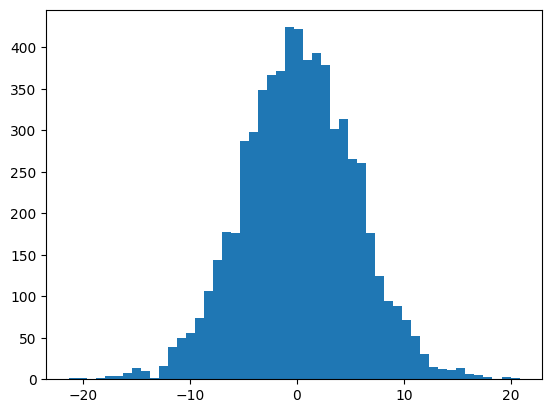

In [44]:
plt.hist(preactivations.view(-1).tolist(), 50)

In [46]:
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

epochs = 1
batch_size = 32
lossi = [ ]

for i in range(epochs):

    # Construct the minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[idxs], Y_train[idxs]

    # Forward pass
    embeddings = C[X_batch]
    concatenated_embeddings = embeddings.view(embeddings.shape[0], -1) # Concatenate the embeddings
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2 # Output layer

    loss = F.cross_entropy(logits, y_batch) # PyTorch will apply softmax internally

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 10_000 else 0.01

    for p in parameters:
        p.data -= lr * p.grad

    break

(array([  1.,   1.,   2.,   1.,   3.,  10.,  16.,  19.,  25.,  34.,  55.,
         55.,  91.,  96., 155., 184., 215., 250., 267., 333., 357., 341.,
        397., 384., 404., 359., 357., 319., 306., 305., 221., 197., 140.,
        106., 100.,  84.,  65.,  54.,  34.,  28.,  12.,   4.,   5.,   3.,
          2.,   1.,   0.,   0.,   1.,   1.]),
 array([-2.0297389 , -1.94485509, -1.85997128, -1.77508746, -1.69020365,
        -1.60531983, -1.52043602, -1.43555221, -1.35066839, -1.26578458,
        -1.18090076, -1.09601695, -1.01113314, -0.92624932, -0.84136551,
        -0.7564817 , -0.67159788, -0.58671407, -0.50183025, -0.41694644,
        -0.33206263, -0.24717881, -0.162295  , -0.07741118,  0.00747263,
         0.09235644,  0.17724026,  0.26212407,  0.34700788,  0.4318917 ,
         0.51677551,  0.60165933,  0.68654314,  0.77142695,  0.85631077,
         0.94119458,  1.0260784 ,  1.11096221,  1.19584602,  1.28072984,
         1.36561365,  1.45049747,  1.53538128,  1.62026509,  1.70514891,
 

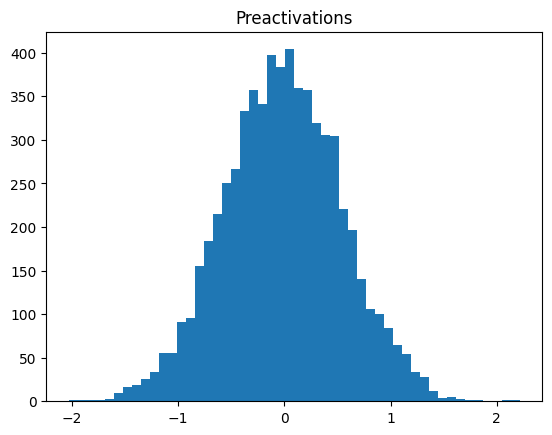

In [49]:

plt.title("Preactivations")
plt.hist(preactivations.view(-1).tolist(), 50)


(array([  6.,  30.,  44.,  73.,  61.,  93.,  91., 110., 126., 141., 145.,
        147., 155., 140., 166., 174., 183., 172., 181., 165., 156., 188.,
        194., 165., 181., 186., 191., 164., 169., 160., 183., 148., 157.,
        172., 165., 176., 164., 155., 124., 138., 109.,  93.,  87.,  92.,
         89.,  84.,  55.,  35.,  12.,   5.]),
 array([-0.96606952, -0.92721961, -0.8883697 , -0.84951978, -0.81066987,
        -0.77181996, -0.73297005, -0.69412014, -0.65527023, -0.61642031,
        -0.5775704 , -0.53872049, -0.49987058, -0.46102067, -0.42217076,
        -0.38332084, -0.34447093, -0.30562102, -0.26677111, -0.2279212 ,
        -0.18907129, -0.15022137, -0.11137146, -0.07252155, -0.03367164,
         0.00517827,  0.04402818,  0.0828781 ,  0.12172801,  0.16057792,
         0.19942783,  0.23827774,  0.27712765,  0.31597757,  0.35482748,
         0.39367739,  0.4325273 ,  0.47137721,  0.51022712,  0.54907704,
         0.58792695,  0.62677686,  0.66562677,  0.70447668,  0.74332659,
 

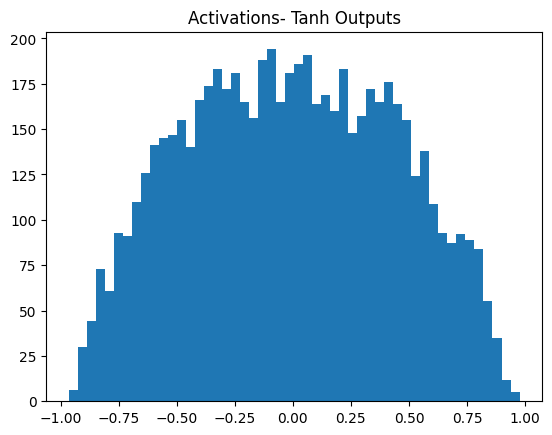

In [50]:
plt.title("Activations- Tanh Outputs")
plt.hist(activations.view(-1).tolist(), 50)

This is much better. We have a much less saturated tanh.